# Demo:

A demonstration of how the functions in the 'hauptstimme' package can be used.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from music21 import converter
from music21.stream.base import Score
from pathlib import Path
from datetime import datetime
from hauptstimme.annotations import get_annotations_and_melody_score
from hauptstimme.score_conversion import (
    score_to_lightweight_df, score_measure_map_to_df, score_to_df
)
from hauptstimme.part_relations import get_part_relationship_summary
from hauptstimme.segmentation import (
    get_score_audio, get_hauptstimme_segmentation_points, get_seg_pts_vec, 
    novelty_based_segmentation, changepoint_segmentation, evaluate_seg_pts, 
    plot_seg_pts_eval
)
from hauptstimme.alignment.scraping import get_imslp_audio_files
from hauptstimme.alignment.score_audio_alignment import (
    align_score_audios, align_hauptstimme_annotations, 
    alignment_table_to_measure_timestamps
)
from hauptstimme.alignment.tempo_curves import (
    alignment_table_to_tempo_curves, plot_alignment_table_tempo_curves
)
from hauptstimme.compare_annotations import *
from hauptstimme.utils import ms3_convert, get_compressed_measure_map
from hauptstimme.constants import CORPUS_PATH, SAMPLE_RATE
from hauptstimme.types import RecFileMetadata
from typing import cast, List

In [2]:
score_mscz = CORPUS_PATH / "Beethoven,_Ludwig_van/Symphony_No.2,_Op.36/1/Beethoven_Op.36_1.mscz"
demo_dir = "demo_files"

### Getting/loading corpus files for a score:

In [3]:
# Get .mxl file
ms3_convert(CORPUS_PATH, "mscz", "mxl", score_mscz.stem)

In [3]:
# Load .mxl file
score_mxl = score_mscz.with_suffix(".mxl")
score_ = converter.parse(score_mxl)
if not isinstance(score_, Score):
    raise ValueError(
        "Error: Score is not of type 'music21.stream.Score'."
    )
score = cast(Score, score_)

In [ ]:
# Get measure map
score_mm = get_compressed_measure_map(score_mscz)

A quick note about computing measure maps at the time of producing this notebook (Aug 2024)...

Our code uses the `ms3` package's `extract` command to extract measure information about the score, which is then used to build the measure map. During development, we discovered that this command ignores 'Fine' markings in voltas, which results in the score having no defined ending in this information, which causes infinite loops in later code such as `score_measure_map_to_df`.

If you encounter similar issues, we used the following workaround:
- Find the `ms3` source code: run `pip show ms3` in the command line and see the 'Location',
- Navigate to this folder, then to ms3/bs4_measures.py,
- Replace lines 935-940 in this file with `self.next[fine_mc].append(-1)`.

In [4]:
# Load measure map
score_mm = score_mscz.with_suffix(".mm.json")
score_mm_df = pd.read_json(score_mm)

In [5]:
# Get annotations file and melody score - may need to adjust 
# `lyrics_not_text` and `annotation_restrictions`
get_annotations_and_melody_score(score_mxl)

Retrieved 86 annotations.


In [5]:
# Load annotations file and melody score
score_annotations = score_mscz.parent / f"{score_mscz.stem}_annotations.csv"
score_annotations_df = pd.read_csv(score_annotations)
melody_score = converter.parse(score_mscz.parent / f"{score_mscz.stem}_melody.mxl")

In [ ]:
# Get lightweight score file
score_lw_df = score_to_lightweight_df(score_mxl)

In [6]:
# Load lightweight score file
score_lw = score_mscz.with_suffix(".csv")
score_lw_df = pd.read_csv(score_lw)

### Score conversion:

In [ ]:
# Get data frame of note events
# Note that running `score_to_df` on the score with repeats expanded 
# gets the same data frame without the `score_qstamp` column
score_df = score_measure_map_to_df(score, score_mm_df)
note_events = f"{demo_dir}/{score_mscz.stem}_note_events.csv"
score_df.to_csv(note_events, index=False)

In [7]:
# Load data frame of note events
note_events = f"{demo_dir}/{score_mscz.stem}_note_events.csv"
score_df = pd.read_csv(note_events)

### Part relationship summaries:

In [8]:
# Get part relationship summary for score
score_summary_df = get_part_relationship_summary(score_mxl, score_lw, score_annotations)
score_summary_df.to_csv(f"{score_mscz.parent}/{score_mscz.stem}_part_relations.csv", index=False)

In [8]:
# Load part relationship summary for score
score_summary = f"{score_mscz.parent}/{score_mscz.stem}_part_relations.csv"
score_summary_df = pd.read_csv(score_summary)

### Segmentation:

In [19]:
# Get score audio
score_audio = get_score_audio(score_mxl, demo_dir)

In [9]:
# Load first 120s of score audio
score_audio = f"{demo_dir}/{score_mscz.stem}.mp3"
audio, _ = librosa.load(score_audio)
audio = audio[:120*SAMPLE_RATE]

In [10]:
# Declare what to round each timestamp to
round_to = 0.25
# Declare the maximum timestamp of the audio
max_tstamp = 120
# Declare the tolerance when comparing timestamps
tau = 4     # Tolerance of 1 second

In [11]:
# Get Hauptstimme annotation segmentation points
haupt_seg_pts = get_hauptstimme_segmentation_points(score_lw, score_annotations, tstamp=True)
haupt_seg_pts_vec = get_seg_pts_vec(haupt_seg_pts, round_to, max_tstamp)

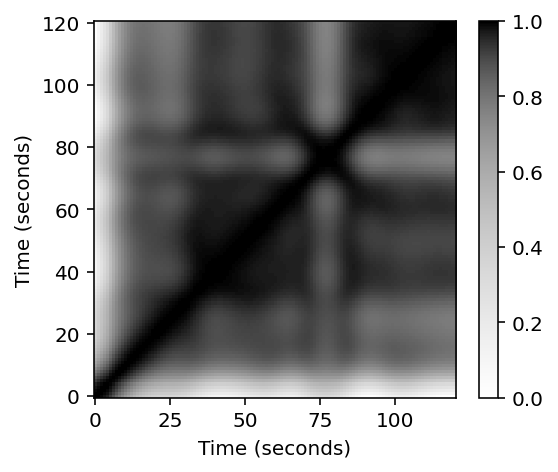

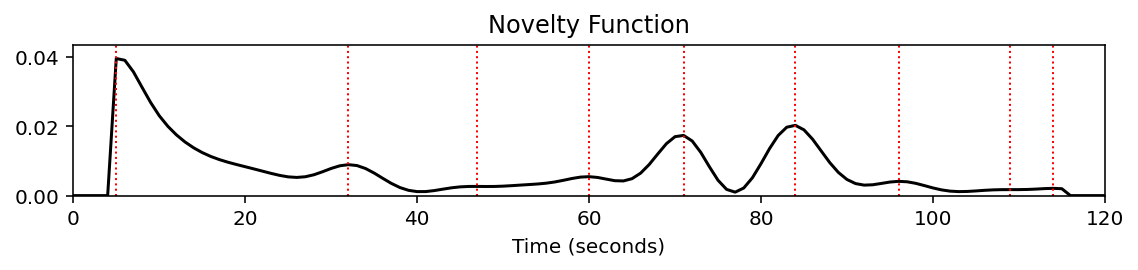

In [12]:
# Obtain novelty-based, tempogram-based segmentation points
nb_seg_pts = novelty_based_segmentation(audio, plot=True)
nb_seg_pts_vec = get_seg_pts_vec(nb_seg_pts, round_to, max_tstamp)

Hauptstimme points compared to novelty-based, tempogram-based segmentation points:
P = 0.444;  R = 0.138;  F = 0.211


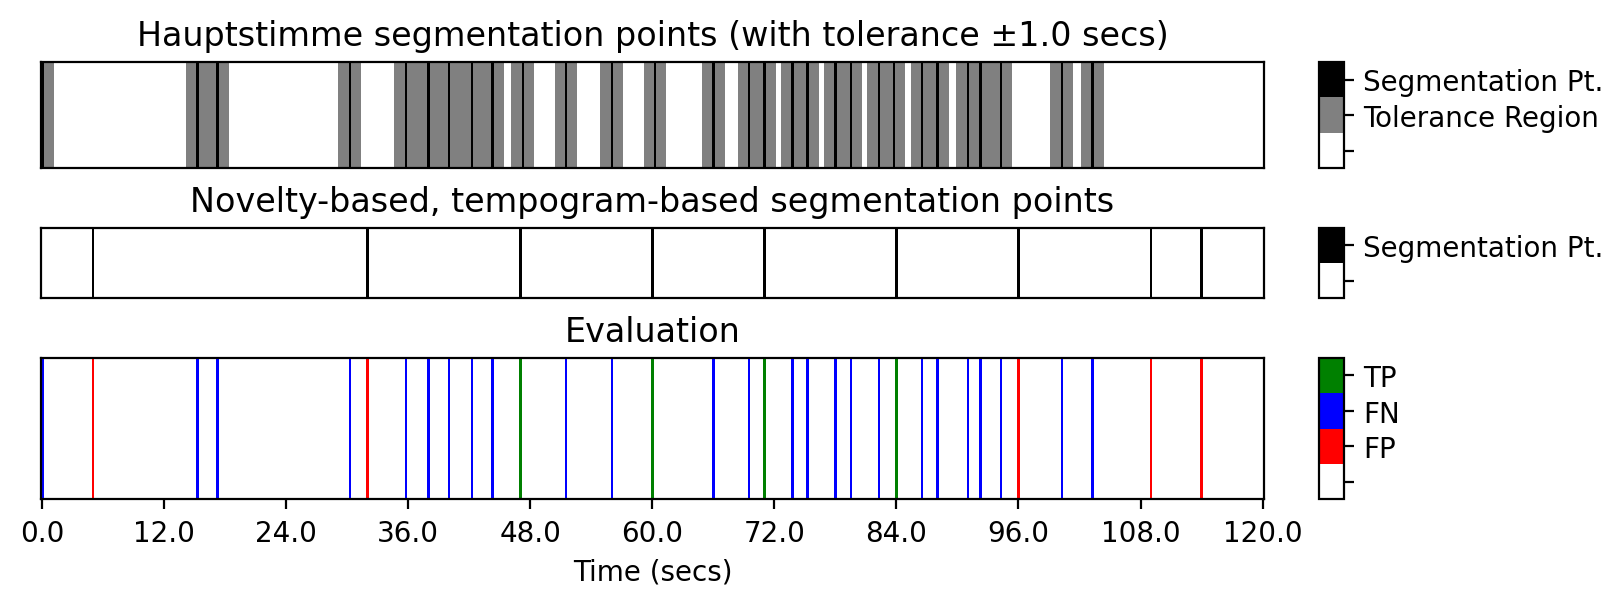

In [13]:
# Plot the segmentation points comparison
P, R, F, _, _, _, _, _ = evaluate_seg_pts(haupt_seg_pts_vec, nb_seg_pts_vec, tau)
print("Hauptstimme points compared to novelty-based, tempogram-based segmentation points:")
print("P = %0.3f;  R = %0.3f;  F = %0.3f" % (P, R, F))
fig, ax = plot_seg_pts_eval(
    haupt_seg_pts_vec, nb_seg_pts_vec, tau, round_to, other_seg_pts="Novelty-based, tempogram-based"
)

In [ ]:
# Obtain novelty-based, chromagram-based segmentation points
nb_seg_pts = novelty_based_segmentation(audio, plot=True, features="chromagram")
nb_seg_pts_vec = get_seg_pts_vec(nb_seg_pts, round_to, max_tstamp)

In [ ]:
# Plot the segmentation points comparison
P, R, F, _, _, _, _, _ = evaluate_seg_pts(haupt_seg_pts_vec, nb_seg_pts_vec, tau)
print("Hauptstimme points compared to novelty-based, chromagram-based segmentation points:")
print("P = %0.3f;  R = %0.3f;  F = %0.3f" % (P, R, F))
fig, ax = plot_seg_pts_eval(
    haupt_seg_pts_vec, nb_seg_pts_vec, tau, round_to, other_seg_pts="Novelty-based, chromagram-based"
)

In [16]:
# Obtain changepoint detection segmentation points
cd_seg_pts = changepoint_segmentation(audio)
cd_seg_pts_vec = get_seg_pts_vec(cd_seg_pts, round_to, 120)

In [ ]:
# Plot the segmentation points comparison
P, R, F, _, _, _, _, _ = evaluate_seg_pts(
    haupt_seg_pts_vec, cd_seg_pts_vec, tau
)
print("Hauptstimme points compared to changepoint detection-based segmentation points:")
print("P = %0.3f;  R = %0.3f;  F = %0.3f" % (P, R, F))
fig, ax = plot_seg_pts_eval(
    haupt_seg_pts_vec, cd_seg_pts_vec, tau, round_to, other_seg_pts="Changepoint detection"
)

### Getting IMSLP audio recordings for score:

In [3]:
# Get IMSLP wiki page URL for the set that the score is in 
sets = CORPUS_PATH / "sets.tsv"
sets_df = pd.read_csv(sets, sep="\t")

set_path = Path(*score_mscz.relative_to(CORPUS_PATH).parts[:2])
set_url = sets_df.loc[sets_df["path"] == set_path, "imslp_link"].item()

In [4]:
# Get metadata for the audio recordings on the wiki page
imslp_audio_metadata = get_imslp_audio_files(set_url, "EU")
for rec in imslp_audio_metadata:
    print(f"Performers: {rec['performers']}")
    print(f"Publisher: {rec['publisher']}")
    print(f"Year: {rec['year']}")
    rec_files = cast(List[RecFileMetadata], rec["recording_files"])
    for rec_file in rec_files:
        print(f"\tRecording #{rec_file['imslp_number']}: {rec_file['name']}")
        print(f"\tLink: {rec_file['imslp_link']}")

Performers: Pittsburgh Symphony Orchestra, William Steinberg
Publisher: Command. CC 11024 SD.
Year: 1964
	Recording #736441: 1. Adagio molto — Allegro con brio
	Link: https://imslp.org/images/8/83/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Opus_36-_Adagio_Molto%2C_Allegro_Con_Brio.mp3
	Recording #736442: 2. Larghetto
	Link: https://imslp.org/images/a/a6/PMLP2580-02.02._Symphony_No._2_In_D_Major%2C_Opus_36-_Larghetto.mp3
	Recording #736443: 3. Scherzo. Allegro vivo
	Link: https://imslp.org/images/f/f2/PMLP2580-02.03._Symphony_No._2_In_D_Major%2C_Opus_36-_Scherzo-_Allegro.mp3
	Recording #736444: 4. Allegro molto
	Link: https://imslp.org/images/6/64/PMLP2580-02.04._Symphony_No._2_In_D_Major%2C_Opus_36-_Allegro_Molto.mp3
Performers: Royal Philharmonic Orchestra, René Leibowitz
Publisher: Reader's Digest. RDA-6 (1-7).
Year: 1961
	Recording #729167: 1. Adagio molto — Allegro con brio
	Link: https://imslp.org/images/c/c3/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Op._36-_First_Movement_-_

### Alignment:

In [11]:
# Get score ID
scores = CORPUS_PATH / "scores.tsv"
scores_df = pd.read_csv(scores, sep="\t")
score_path = score_mscz.parent.relative_to(CORPUS_PATH).as_posix()
score_id = scores_df.loc[scores_df["path"] == score_path, "id"].item()

In [12]:
# Get audios for the score
audios = pd.read_csv(CORPUS_PATH / "audios.tsv", sep="\t")
score_audios = audios[audios["score_id"] == score_id]

# Create list of audio data for alignment
score_audio_files = []
for _, audio in score_audios.iterrows():
    score_audio_files.append([audio["imslp_number"], audio["imslp_link"], None, None])

In [13]:
# Also include audio for the Beethoven proof of concept YouTube video
start_time = datetime.strptime("00:00:07", "%H:%M:%S").time()
end_time = datetime.strptime("00:12:10", "%H:%M:%S").time()
demo_audio_id = "RNS"
score_audio_files.append([demo_audio_id, f"{demo_dir}/{demo_audio_id}_{score_mscz.stem}.mp3", start_time, end_time])

In [57]:
# Get alignment table using previously computed note events data frame
score_alignment_df = align_score_audios(score_mxl, score_mm, score_audio_files, out_dir=demo_dir, note_events=note_events)

Aligning audio file 'https://imslp.org/images/8/83/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Opus_36-_Adagio_Molto%2C_Allegro_Con_Brio.mp3' to the score 'Beethoven_Op.36_1.mxl'.
Estimated tuning deviation for recording: 22 cents
................................................................................................................................................................................
Pitch shift between the audio recording and score, determined by DTW: 0 bins

Aligning audio file 'https://imslp.org/images/c/c3/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Op._36-_First_Movement_-_Adagio_Molto%3B_Allegro_Con_Brio.mp3' to the score 'Beethoven_Op.36_1.mxl'.
Estimated tuning deviation for recording: 22 cents
................................................................................................................................................................................
Pitch shift between the audio recording and score, determined by DTW: 0 bins

Aligning a

In [14]:
# Load alignment table
score_alignment = f"{demo_dir}/{score_mscz.stem}_alignment.csv"
score_alignment_df = pd.read_csv(score_alignment)

### Tempo curves:

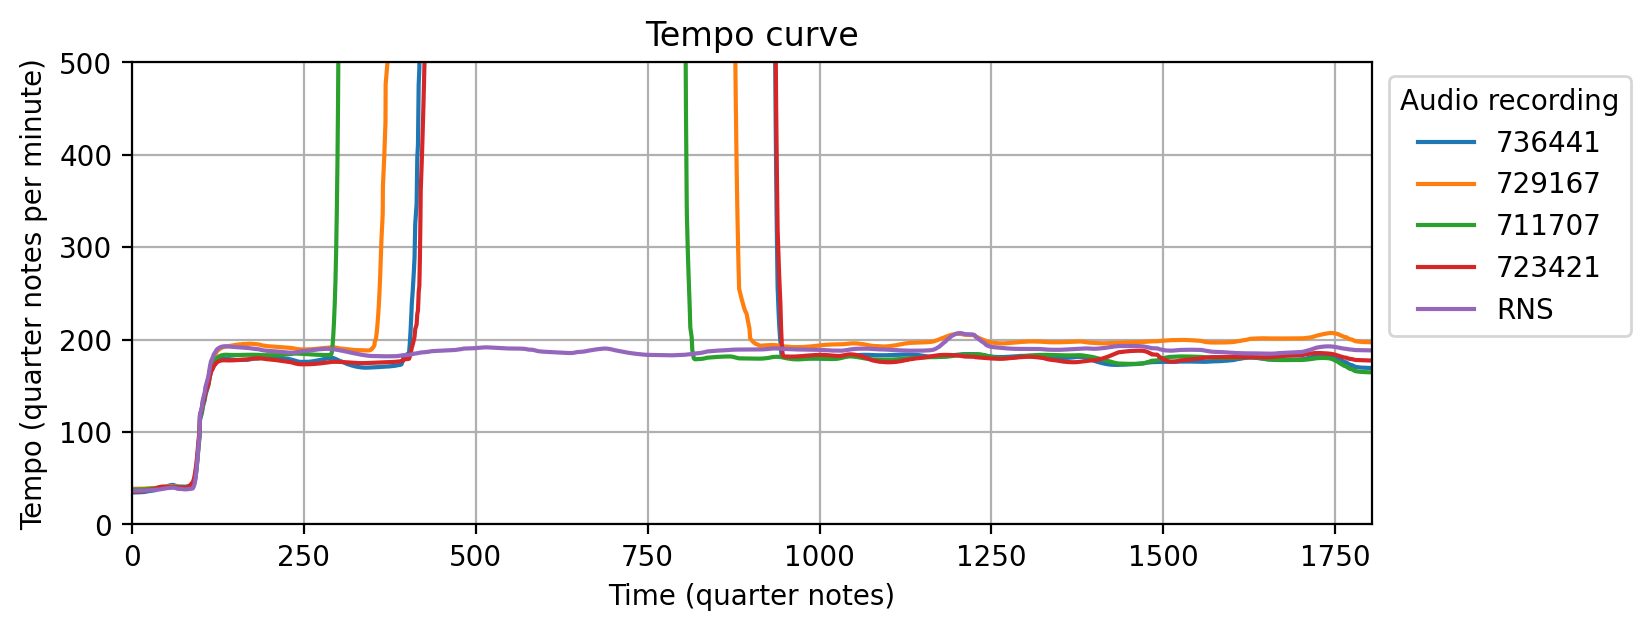

In [15]:
# Plot tempo curves for the audio recordings
tempo_curves = alignment_table_to_tempo_curves(score_alignment_df)
plot_alignment_table_tempo_curves(score_alignment_df, tempo_curves, "qstamp", ylim=(0, 500))
plt.show()
# As we can see, all IMSLP recordings skip the repeat, whereas the 
# proof of concept video (RNS) does not

In [8]:
# Get note events for score without repeats expanded
no_repeats_note_events = f"{demo_dir}/{score_mscz.stem}_no_repeats_note_events.csv"
score_no_repeats_df = score_to_df(score)
score_no_repeats_df["score_qstamp"] = score_no_repeats_df["qstamp"] # Add score_qstamp column
score_no_repeats_df = score_no_repeats_df[
    score_no_repeats_df.columns[[-1, *range(0, len(score_no_repeats_df.columns) - 1)]]
]
score_no_repeats_df.to_csv(no_repeats_note_events, index=False)


Converting score to a data frame containing all note events...
Conversion successful.


In [29]:
# Load note events for score without repeats expanded
no_repeats_note_events = f"{demo_dir}/{score_mscz.stem}_no_repeats_note_events.csv"
score_no_repeats_df = pd.read_csv(no_repeats_note_events)

In [30]:
# Align audios to the score without repeats expanded to inspect this
score_no_repeats_alignment_df = align_score_audios(
    score_mxl, score_mm, score_audio_files, no_repeats_note_events
)
score_no_repeats_alignment = f"{demo_dir}/{score_mscz.stem}_no_repeats_alignment.csv"
os.rename(f"{score_mscz.stem}_alignment.csv", score_no_repeats_alignment)


Aligning audio file 'https://imslp.org/images/8/83/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Opus_36-_Adagio_Molto%2C_Allegro_Con_Brio.mp3' to the score 'Beethoven_Op.36_1.mxl'.
Estimated tuning deviation for recording: 22 cents
................................................................................................................................................................................
Pitch shift between the audio recording and score, determined by DTW: 0 bins

Aligning audio file 'https://imslp.org/images/c/c3/PMLP2580-02.01._Symphony_No._2_In_D_Major%2C_Op._36-_First_Movement_-_Adagio_Molto%3B_Allegro_Con_Brio.mp3' to the score 'Beethoven_Op.36_1.mxl'.
Estimated tuning deviation for recording: 22 cents
................................................................................................................................................................................
Pitch shift between the audio recording and score, determined by DTW: 0 bins

Aligning 

In [26]:
# Load alignment table for score without repeats expanded
score_no_repeats_alignment = f"{demo_dir}/{score_mscz.stem}_no_repeats_alignment.csv"
score_no_repeats_alignment_df = pd.read_csv(score_no_repeats_alignment)

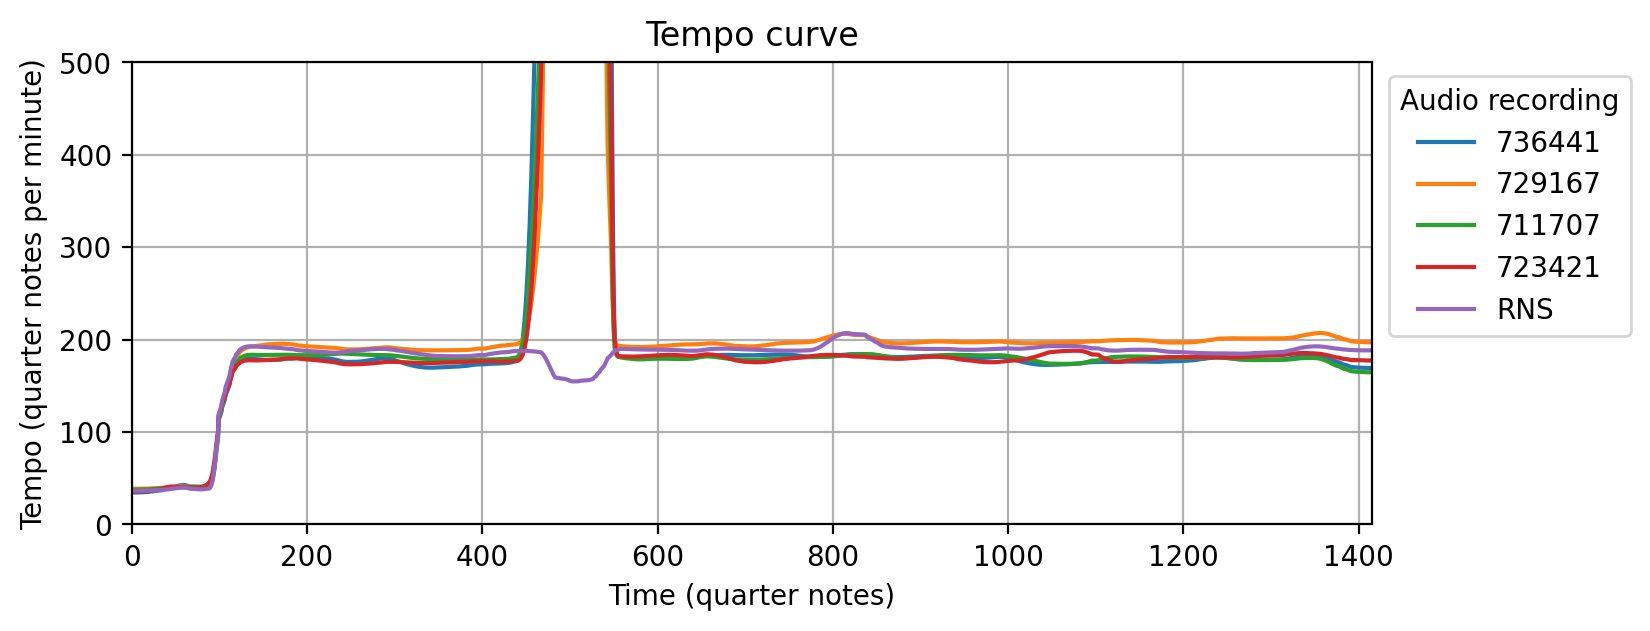

Measure range: 122-147


In [18]:
# There are still high tempos (up to 6000 quarter notes per minute) in 
# the measure range 122-147
tempo_curves = alignment_table_to_tempo_curves(score_no_repeats_alignment_df)
plot_alignment_table_tempo_curves(score_no_repeats_alignment_df, tempo_curves, "qstamp", ylim=(0, 500))
plt.show()

measure_range = score_no_repeats_alignment_df.loc[
    (score_no_repeats_alignment_df["qstamp"] >= 450) & (score_no_repeats_alignment_df["qstamp"] <= 550),
    "measure"
]
print(f"Measure range: {measure_range.min()}-{measure_range.max()}")
# The high tempos around the end repeat barline are because one of the 
# two voltas is not played
# In this region there is also a dip in the tempos of the RNS recording 
# because the repeat is played
# To inspect which of the two is played, we would need to recreate the 
# score without repeats, which we will not do here

### Aligning Hauptstimme annotations to audio:

In [21]:
# Align the Hauptstimme annotations to the audio
aligned_annotations_df = align_hauptstimme_annotations(
    score_alignment, score_annotations, demo_dir
)


The aligned annotations were saved to 'demo_files/Beethoven_Op.36_1_annotations_aligned.csv'.


### Conversion for TiLiA beat timeline:

In [22]:
# Obtain a file containing timestamps for the start of each measure
# This can be imported into a TiLiA beat timeline
measure_tstamps = alignment_table_to_measure_timestamps(
    score_alignment, demo_audio_id, demo_dir
)


The measure timestamps were saved to 'demo_files/RNS_measure_tstamps.csv'.


### Comparison of Hauptstimme annotations and video annotations:

In [15]:
# Get aligned Hauptstimme annotations
aligned_annotations = f"{demo_dir}/{score_mscz.stem}_annotations_aligned.csv"
aligned_annotations_df = pd.read_csv(aligned_annotations)
score_tstamp_col = f"{demo_audio_id}_tstamp"
score_annotation_col = "instrument"

# Get video annotations
video_annotations = f"{demo_dir}/{demo_audio_id}_{score_mscz.stem}.csv"
video_annotations_df = pd.read_csv(video_annotations)
video_tstamp_col = "scene_start"
video_annotation_col = "focal_instrument"

# Declare what to round each timestamp to
round_to = 0.25
# Declare the start and end timestamps of the video
start_tstamp = (start_time.hour*60 + start_time.minute) * 60 + start_time.second
end_tstamp = (end_time.hour*60 + end_time.minute) * 60 + end_time.second
# Declare the tolerance when comparing timestamps
tau = 4     # Tolerance of 1 second

In [16]:
# Convert the video annotations to a vector indicating the annotation 
# value every 0.25 seconds
video_annotations_df[video_annotation_col] = get_default_instrument_names(
    video_annotations_df[video_annotation_col]
)
video_annotations_vec = get_annotations_vec(
    video_annotations_df, video_tstamp_col, video_annotation_col, round_to, start_tstamp, end_tstamp
)

Compare the instruments:

In [17]:
haupt_video_comparison(aligned_annotations_df, score_summary_df, video_annotations_vec, score_tstamp_col, round_to, start_tstamp)

Match percentage: 17.97442101624611
Partial match percentage: 6.809540269616315
No match percentage: 45.69650881437954
Can't match percentage: 29.519529899758034


Compare the timestamps:

In [18]:
# Get vectors for the annotation segmentation points
haupt_seg_pts = aligned_annotations_df[score_tstamp_col].to_list()
haupt_seg_pts_vec = get_seg_pts_vec(haupt_seg_pts, round_to, end_tstamp)

video_seg_pts = video_annotations_df[video_tstamp_col].to_list()
video_seg_pts_vec = get_seg_pts_vec(
    video_seg_pts, round_to, end_tstamp
)

Hauptstimme points compared to video points:
P = 0.853;  R = 0.462;  F = 0.599


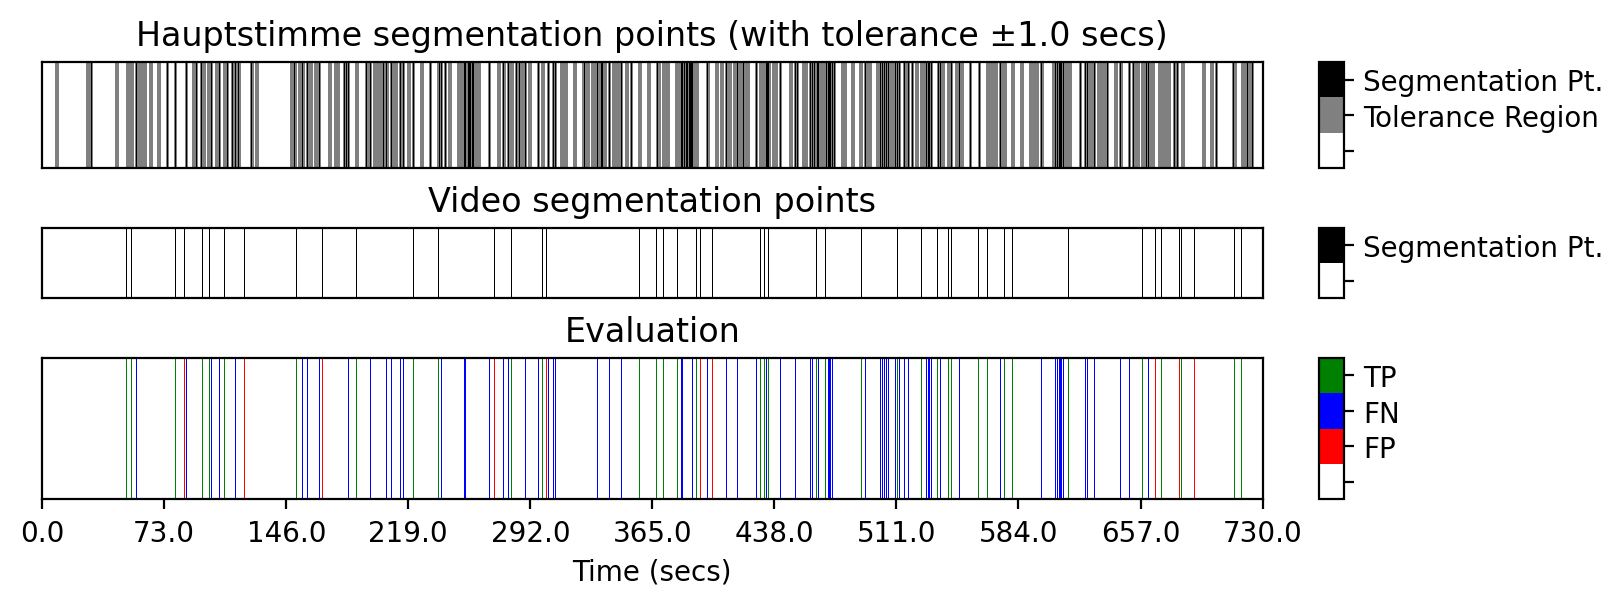

In [19]:
P, R, F, _, _, _, _, _ = evaluate_seg_pts(
    haupt_seg_pts_vec, video_seg_pts_vec, tau
)
print("Hauptstimme points compared to video points:")
print("P = %0.3f;  R = %0.3f;  F = %0.3f" % (P, R, F))
fig, ax = plot_seg_pts_eval(
    haupt_seg_pts_vec, video_seg_pts_vec, tau, round_to, other_seg_pts="Video"
)